[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

**<font color='orange'>If you like this notebook, don't forget to show your support with your upvote!</font>**

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e384c72d-668c-3415-5e06-024bc2418975)
GPU 1: Tesla T4 (UUID: GPU-b906d206-770a-a005-b033-fbb61214d347)


# Installs/Imports

In [2]:
%%time

! pip install ultralytics==8.1.29 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 15.1 MB/s eta 0:00:0000:01
CPU times: user 73 ms, sys: 16.6 ms, total: 89.6 ms
Wall time: 5.07 s


In [3]:
import ultralytics
print(ultralytics.__version__)

8.1.29


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [5]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [6]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 50 # 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/'
    OUTPUT_DIR = './'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [7]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [9]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



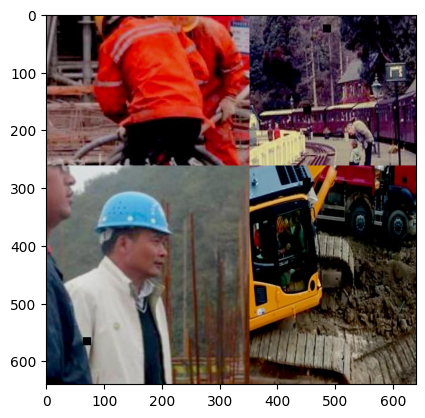

In [10]:
example_image_path = '/kaggle/input/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'

display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

In [11]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

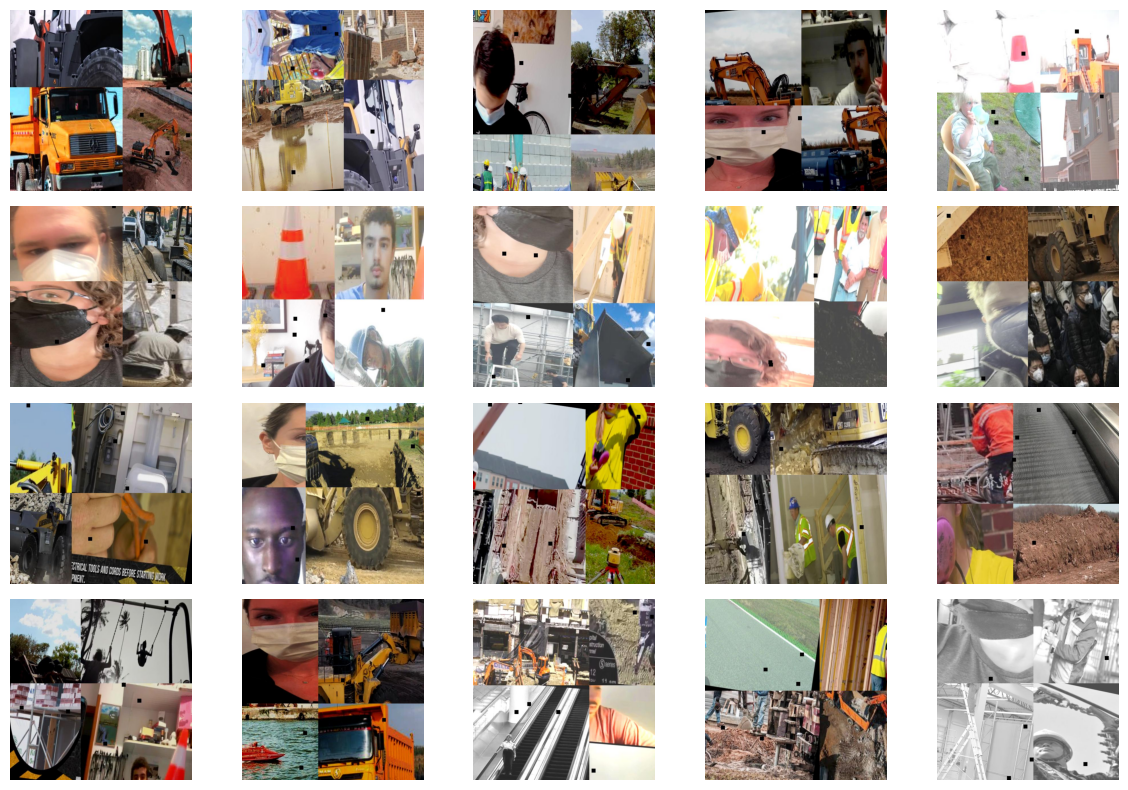

In [12]:
folder_path = "/kaggle/input/css-data/train/images/"
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [13]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [14]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [15]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}
CFG.CUSTOM_DATASET_DIR = "/kaggle/input/css-data/"
class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 176 ms, sys: 220 ms, total: 396 ms
Wall time: 8.78 s


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


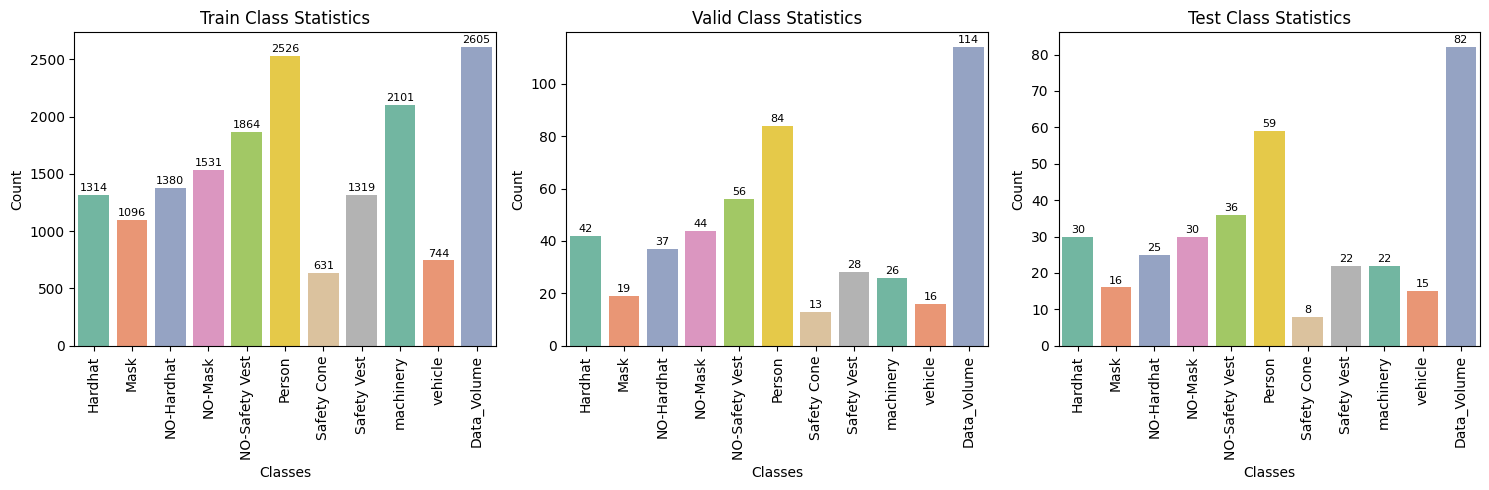

In [16]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [17]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 483 ms, sys: 398 ms, total: 881 ms
Wall time: 11.4 s


In [18]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs


True
2


In [19]:
CFG.BASE_MODEL_WEIGHTS

'yolov8s.pt'

In [20]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source=example_image_path,
    classes=[0],
    conf=0.30,
    device="0,1",  # Correct multi-GPU format
    imgsz=max(img_properties['height'], img_properties['width']),
    save=True,
    save_txt=True,
    save_conf=True,
    exist_ok=True
)


100%|██████████| 21.5M/21.5M [00:00<00:00, 169MB/s]



image 1/1 /kaggle/input/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 9 persons, 16.4ms
Speed: 5.0ms preprocess, 16.4ms inference, 298.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



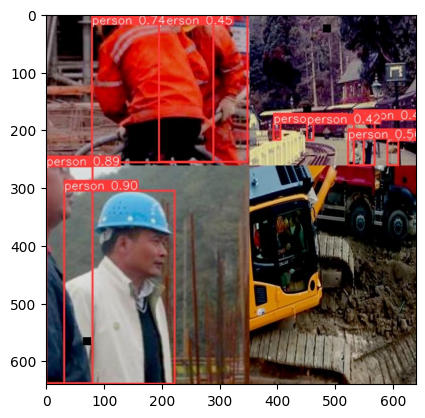

In [21]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/kaggle/working/runs/detect/predict/{example_image_inference_output}')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [22]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8s.pt
Epochs:  50
Batch:  16


In [23]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)
!find /kaggle/input/ -name "data.yaml"
!find /kaggle/working/ -name "data.yaml"


/kaggle/working/data.yaml


In [24]:
yaml_content = """names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
train: /kaggle/input/css-data/train
val: /kaggle/input/css-data/valid
test: /kaggle/input/css-data/test
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml updated successfully!")


data.yaml updated successfully!


In [35]:
!pip install -U "ray[tune]"


In [37]:
import ray
if not hasattr(ray.tune, "is_session_enabled"):
    ray.tune.is_session_enabled = lambda: False


model.train(
    data="/kaggle/working/data.yaml",
    task='detect',
    imgsz=(img_properties['height'], img_properties['width']),
    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    weight_decay=CFG.WEIGHT_DECAY,
    dropout=CFG.DROPOUT,
    fraction=CFG.FRACTION,
    patience=CFG.PATIENCE,
    profile=CFG.PROFILE,
    label_smoothing=CFG.LABEL_SMOOTHING,
    name=f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed=CFG.SEED,
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    device=0,  # Using single GPU to avoid distributed training issues
    verbose=False,
    save=True,
    save_period=1,  # Save best.pt every epoch
)


New https://pypi.org/project/ultralytics/8.3.98 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=1, cache=False, device=0, workers=8, project=None, name=yolov8s_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 84.7MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:02<00:00, 884.97it/s]

train: WARNING ⚠️ /kaggle/input/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/css-data/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 730.54it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/css-data/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8s_ppe_css_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.87G      1.318      2.045      1.439        371        640: 100%|██████████| 163/163 [00:49<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


                   all        114        697      0.679      0.481      0.551      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.83G      1.218      1.464      1.362        279        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        114        697      0.733      0.493      0.567      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.53G      1.196      1.395      1.354        227        640: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        114        697      0.709       0.46      0.519      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.88G       1.18      1.344      1.346        240        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


                   all        114        697      0.725      0.528      0.568      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.33G      1.168      1.288      1.328        385        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        114        697      0.725      0.534      0.603      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.21G      1.141      1.207      1.304        302        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697      0.772      0.576      0.636      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.46G      1.116      1.149      1.289        246        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        114        697      0.697      0.575      0.624      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         5G      1.089      1.106      1.269        325        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        114        697      0.792      0.617      0.672      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.29G      1.073      1.074       1.26        205        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        114        697       0.78      0.658      0.713      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.94G      1.058      1.043      1.246        215        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        114        697      0.796      0.599       0.68      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.88G       1.03     0.9993      1.229        292        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        114        697       0.78      0.649      0.704      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.02G      1.022     0.9742      1.222        265        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        114        697      0.857      0.627      0.724      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.92G       1.01     0.9473      1.212        215        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        114        697      0.817      0.652       0.72      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       5.2G     0.9959     0.9216      1.206        170        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        114        697      0.853      0.637      0.739      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.78G     0.9825     0.8917      1.193        335        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        114        697      0.835      0.654      0.736      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.08G     0.9725     0.8844      1.187        336        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        114        697      0.831      0.681      0.751      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.71G     0.9548     0.8658      1.179        228        640: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        114        697      0.879      0.635      0.743      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.85G     0.9514     0.8562      1.179        282        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        114        697      0.833      0.687      0.752       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.98G     0.9399     0.8307       1.17        271        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        114        697      0.894      0.664      0.759       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.11G     0.9235     0.8104      1.156        244        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        114        697      0.843      0.696      0.766      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       5.2G     0.9184     0.7975      1.151        161        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        114        697      0.863      0.685      0.764      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.42G     0.9086     0.7786      1.146        249        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        114        697      0.881      0.711      0.789      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.92G      0.895     0.7631      1.134        253        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        114        697      0.873      0.707      0.789      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.91G     0.8866     0.7546      1.129        302        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


                   all        114        697      0.848       0.74      0.802      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       4.8G     0.8636     0.7315       1.12        214        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        114        697      0.862      0.729      0.797      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.27G     0.8672     0.7258      1.115        233        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        114        697      0.893       0.69      0.786      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       4.5G     0.8529     0.7114       1.11        322        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        114        697       0.86      0.737      0.797      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       5.8G     0.8439     0.6964       1.11        269        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        114        697      0.872      0.735      0.806      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.02G     0.8422      0.694      1.099        174        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        697      0.884       0.74      0.805      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.99G     0.8335     0.6888      1.095        201        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        697      0.889      0.726      0.803       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.74G     0.8257     0.6773       1.09        344        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        114        697      0.907      0.731      0.815      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       5.2G     0.8208     0.6635      1.087        303        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        114        697      0.899      0.732      0.811      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.38G     0.8094     0.6563      1.081        396        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        114        697      0.898      0.716       0.81      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.13G     0.8027     0.6409      1.076        209        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        114        697      0.901      0.739      0.815      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       5.1G     0.7989     0.6336      1.074        309        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        114        697      0.889      0.746      0.817      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.68G     0.7952     0.6288      1.073        201        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        114        697      0.906       0.74      0.825      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.78G     0.7842     0.6203      1.063        322        640: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        114        697      0.895      0.746       0.82      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.58G     0.7627     0.6019      1.054        248        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        114        697      0.897      0.767      0.833      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.15G     0.7507     0.5908      1.052        263        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        114        697      0.903      0.764      0.837      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.73G     0.7594     0.5921      1.053        252        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        114        697      0.906      0.762      0.838      0.543


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.57G     0.7648     0.5244      1.049        152        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        114        697      0.909      0.752      0.835      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.76G     0.7415     0.5031      1.039        140        640: 100%|██████████| 163/163 [00:46<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        697      0.917      0.765      0.842      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.66G     0.7256     0.4851      1.026        155        640: 100%|██████████| 163/163 [00:46<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        114        697       0.91      0.771      0.844      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.57G     0.7194     0.4838      1.024        194        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        114        697      0.903      0.764       0.84      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.63G     0.7031     0.4693      1.013        224        640: 100%|██████████| 163/163 [00:46<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        114        697      0.937      0.755      0.845      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.57G     0.6977     0.4642      1.013        181        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        114        697      0.945      0.771      0.848      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.14G     0.6918     0.4607      1.006        128        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        114        697      0.937      0.772      0.848      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.76G     0.6773      0.449          1        177        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        114        697      0.931      0.782       0.85      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.81G      0.664     0.4377     0.9928        159        640: 100%|██████████| 163/163 [00:46<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        697      0.916      0.785      0.853      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.81G     0.6613     0.4359     0.9914        187        640: 100%|██████████| 163/163 [00:46<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        697      0.933      0.775      0.855      0.564



50 epochs completed in 0.698 hours.
Optimizer stripped from runs/detect/yolov8s_ppe_css_50_epochs/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_ppe_css_50_epochs/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_ppe_css_50_epochs/weights/best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


                   all        114        697      0.927      0.777      0.855      0.564
Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolov8s_ppe_css_50_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x783aec4418d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv8 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [44]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [45]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'runs/detect/yolov8s_ppe_css_50_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (21.5 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 1.0s, saved as 'runs/detect/yolov8s_ppe_css_50_epochs/weights/best.onnx' (42.7 MB)

Export complete (1.3s)
Results saved to /kaggle/working/runs/detect/yolov8s_ppe_css_50_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8s_ppe_css_50_epochs/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/yolov8s_ppe_css_50_epochs/weights/best.onnx imgsz=640 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


'runs/detect/yolov8s_ppe_css_50_epochs/weights/best.onnx'

# Train results

In [46]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8s_ppe_css_50_epochs/P_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8s_ppe_css_50_epochs/PR_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs/confusion_matrix.png',
 './runs/detect/yolov8s_ppe_css_50_epochs/R_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs/F1_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs/results.png',
 './runs/detect/yolov8s_ppe_css_50_epochs/labels_correlogram.jpg',
 './runs/detect/yolov8s_ppe_css_50_epochs/labels.jpg']

./runs/detect/yolov8s_ppe_css_50_epochs/F1_curve.png


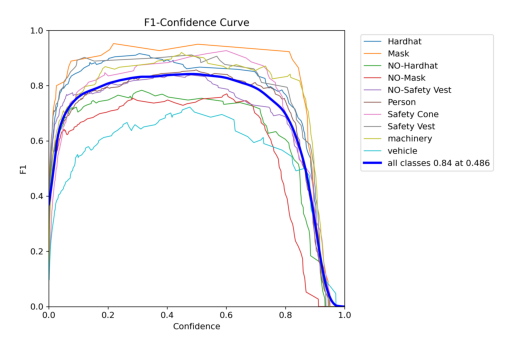



./runs/detect/yolov8s_ppe_css_50_epochs/PR_curve.png


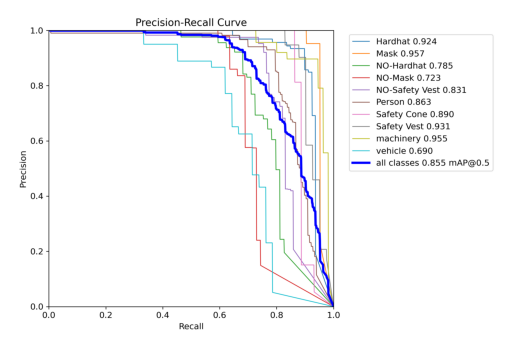



./runs/detect/yolov8s_ppe_css_50_epochs/P_curve.png


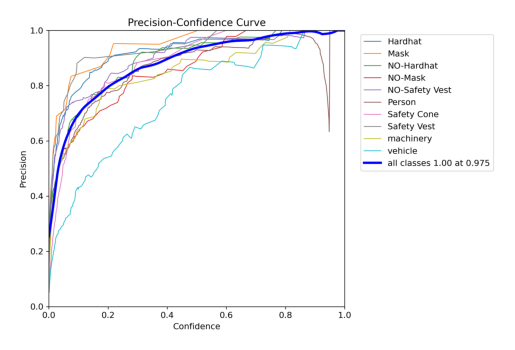



./runs/detect/yolov8s_ppe_css_50_epochs/R_curve.png


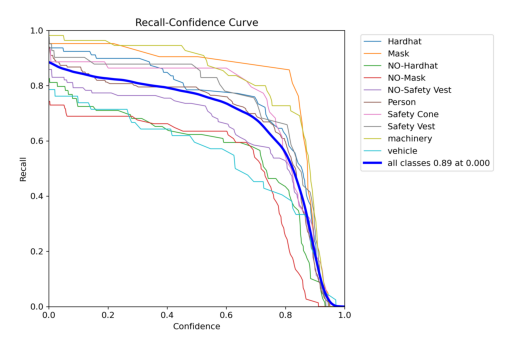



./runs/detect/yolov8s_ppe_css_50_epochs/confusion_matrix.png


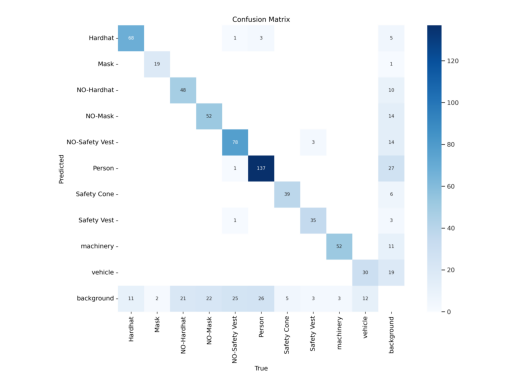



./runs/detect/yolov8s_ppe_css_50_epochs/confusion_matrix_normalized.png


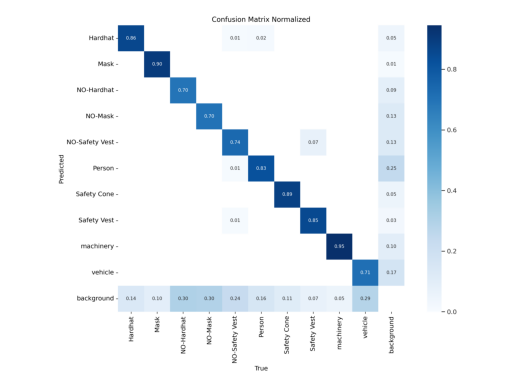



./runs/detect/yolov8s_ppe_css_50_epochs/labels.jpg


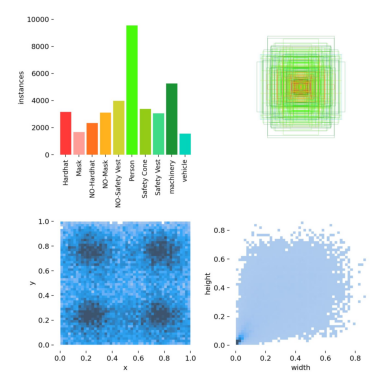



./runs/detect/yolov8s_ppe_css_50_epochs/labels_correlogram.jpg


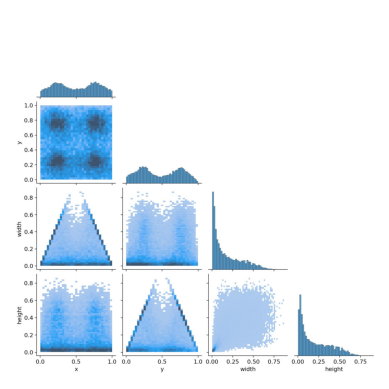



./runs/detect/yolov8s_ppe_css_50_epochs/results.png


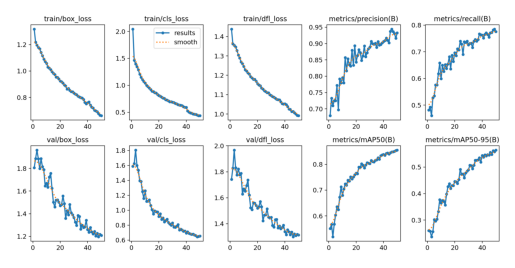

In [47]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

# Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [48]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.31840,2.04460,1.43880,0.67908,0.48120,0.55084,0.26071,1.8047,1.58860,1.7413,0.000237,0.000237,0.000237
1,2,1.21810,1.46400,1.36220,0.73266,0.49258,0.56697,0.25791,1.8854,1.62490,1.8278,0.000465,0.000465,0.000465
2,3,1.19610,1.39490,1.35430,0.70945,0.46034,0.51931,0.23726,1.9609,1.80470,1.9671,0.000684,0.000684,0.000684
3,4,1.17950,1.34410,1.34600,0.72520,0.52758,0.56849,0.25644,1.8845,1.59940,1.8309,0.000672,0.000672,0.000672
4,5,1.16810,1.28770,1.32790,0.72512,0.53425,0.60338,0.30200,1.7976,1.53590,1.7747,0.000672,0.000672,0.000672
5,6,1.14110,1.20680,1.30410,0.77188,0.57572,0.63582,0.29618,1.8858,1.39500,1.8223,0.000657,0.000657,0.000657
6,7,1.11600,1.14890,1.28940,0.69668,0.57545,0.62444,0.30379,1.8141,1.38510,1.7776,0.000643,0.000643,0.000643
7,8,1.08910,1.10640,1.26910,0.79165,0.61748,0.67247,0.33277,1.7884,1.24860,1.7874,0.000629,0.000629,0.000629
8,9,1.07250,1.07380,1.25970,0.77984,0.65772,0.71301,0.37710,1.6452,1.15900,1.6286,0.000615,0.000615,0.000615
9,10,1.05820,1.04250,1.24560,0.79559,0.59892,0.67957,0.36438,1.6684,1.26080,1.6686,0.000601,0.000601,0.000601


In [49]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.66127 , on epoch:  50 


Best Validation Box loss:  1.1969 , on epoch:  48 


Best Training Cls loss:  0.43589 , on epoch:  50 


Best Validation Cls loss:  0.6453 , on epoch:  48 


Best Training DFL loss:  0.99135 , on epoch:  50 


Best Validation DFL loss:  1.2993 , on epoch:  46 



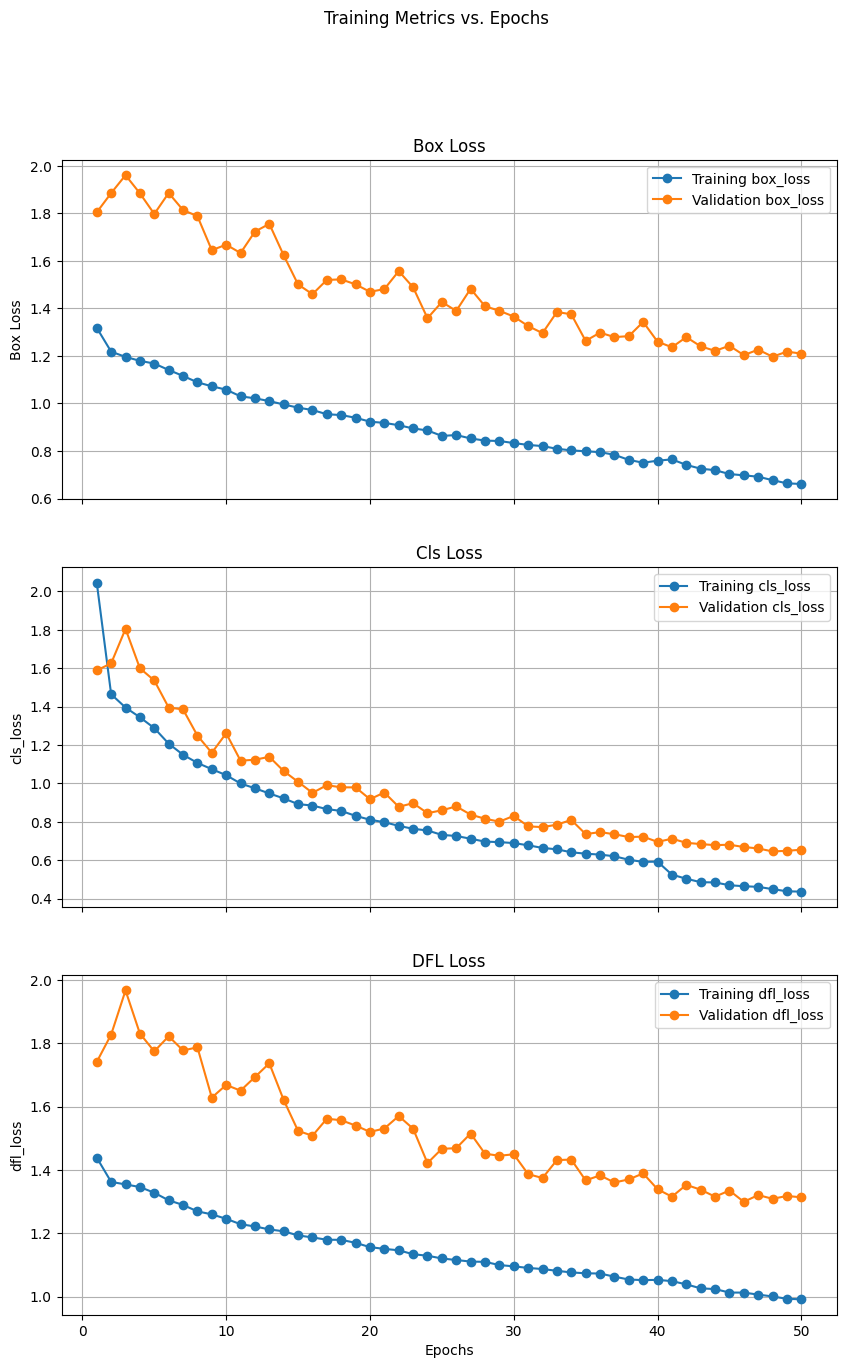

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [51]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [52]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8s_ppe_css_50_epochs/val_batch1_labels.jpg


./runs/detect/yolov8s_ppe_css_50_epochs/val_batch0_pred.jpg


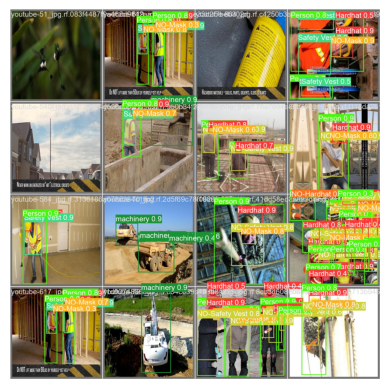

In [53]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)